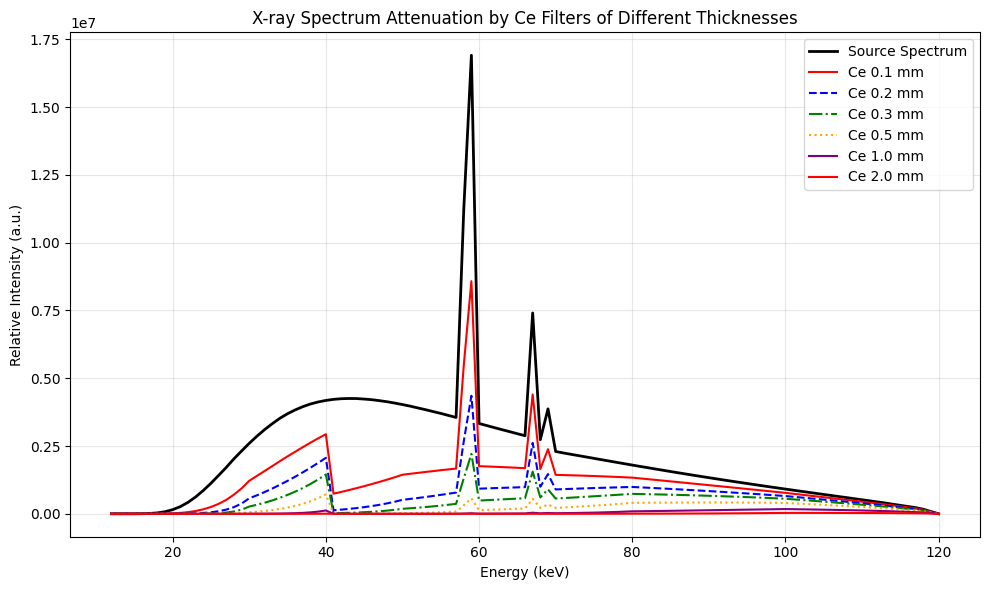

In [2]:
import math, numpy as np

# ---------- 1) 读文件工具（自动跳过非数字行） ----------
def load_two_cols(path):
    E, Y = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            s = ln.strip().split()
            if len(s) < 2: 
                continue
            try:
                e = float(s[0]); y = float(s[1])
            except ValueError:
                continue
            E.append(e); Y.append(y)
    E = np.asarray(E, float); Y = np.asarray(Y, float)
    idx = np.argsort(E)
    return E[idx], Y[idx]

# 2) 输入路径  
spek_path = "spek_120.txt"      # X 射线的原始能谱，由 SpekCalc 导出
xcom_ce_path = "Ce_mu_over_rho.csv"     # XCOM 查表得到 Ce 的 (mu/rho) CSV

# 3) 读取数据 
E_keV, Phi_in = load_two_cols(spek_path)
ce_Ex_MeV, ce_mu_over_rho = load_two_cols(xcom_ce_path)  # Ce

# 单位转换 MeV -> keV
ce_Ex_keV = ce_Ex_MeV * 1000.0

# 4) 参数：Ce 密度与不同厚度
rho_ce = 6.77       # g/cm^3（Ce 密度）

# 定义不同的厚度（单位：mm）
thicknesses_mm = [0.1, 0.2, 0.3, 0.5, 1.0, 2.0]  # 可以根据需要修改这些厚度值

# 5) 计算不同厚度下的透过率
mu_rho_interp_ce = np.interp(E_keV, ce_Ex_keV, 
                          ce_mu_over_rho, left=ce_mu_over_rho[0], 
                          right=ce_mu_over_rho[-1])   # 把 (mu/rho)(E) 插值到 Spek 的能量点
mu_cm_inv_ce = mu_rho_interp_ce * rho_ce          # 线性衰减系数 mu(E) [cm^-1]

# 存储不同厚度的结果
Phi_out_results = []

for thickness_mm in thicknesses_mm:
    x_cm = thickness_mm * 0.1  # mm -> cm
    T_ce = np.exp(-mu_cm_inv_ce * x_cm)         # 透过率
    Phi_out = Phi_in * T_ce                     # 衰减后的谱
    Phi_out_results.append(Phi_out)

# ---------- 6) 保存结果（可选） ----------
# 如果需要保存某个厚度的结果，可以取消注释下面的代码
# np.savetxt("spectrum_filtered_Ce_0_5mm.txt", np.column_stack([E_keV, Phi_out_results[1]]),
#            header="Energy_keV  Phi_filtered", fmt="%.6f")

# ---------- 7) 画图 ----------
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(E_keV, Phi_in, 'k-', linewidth=2, label="Source Spectrum")
    
    # 为不同厚度使用不同的颜色和线型
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    linestyles = ['-', '--', '-.', ':', '-']
    
    for i, (thickness_mm, Phi_out) in enumerate(zip(thicknesses_mm, Phi_out_results)):
        plt.plot(E_keV, Phi_out, 
                color=colors[i % len(colors)], 
                linestyle=linestyles[i % len(linestyles)],
                label=f"Ce {thickness_mm} mm")
    
    plt.xlabel("Energy (keV)")
    plt.ylabel("Relative Intensity (a.u.)")
    plt.title("X-ray Spectrum Attenuation by Ce Filters of Different Thicknesses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib not available, skipping plot")
except Exception as e:
    print(f"Plotting error: {e}")